# 🏟️ Predict Future Hall of Famers (Lahman + scikit-learn)
This notebook loads local Parquet files, builds features from batting/pitching stats, and trains models to predict Hall of Fame induction.

In [5]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


## 📂 Load Local Parquet Files

In [6]:

people_path = "/Users/todd/Desktop/csvdatabase/People/People.parquet"
batting_path = "/Users/todd/Desktop/csvdatabase/Batting/Batting.parquet"
pitching_path = "/Users/todd/Desktop/csvdatabase/Pitching/Pitching.parquet"
hof_path = "/Users/todd/Desktop/csvdatabase/HallOfFame/HallOfFame.parquet"

people = pd.read_parquet(people_path)
batting = pd.read_parquet(batting_path)
pitching = pd.read_parquet(pitching_path)
hof = pd.read_parquet(hof_path)

people.head()


,ID,playerID,birthYear,birthMonth,birthDay,birthCity,birthCountry,birthState,deathYear,deathMonth,...,nameLast,nameGiven,weight,height,bats,throws,debut,bbrefID,finalGame,retroID
0,1,aardsda01,1981.0,12.0,27.0,Denver,USA,CO,NaN,NaN,...,Aardsma,David Allan,215.0,75.0,R,R,2004-04-06,aardsda01,2015-08-23,aardd001
1,2,aaronha01,1934.0,2.0,5.0,Mobile,USA,AL,2021.0,1.0,...,Aaron,Henry Louis,180.0,72.0,R,R,1954-04-13,aaronha01,1976-10-03,aaroh101
2,3,aaronto01,1939.0,8.0,5.0,Mobile,USA,AL,1984.0,8.0,...,Aaron,Tommie Lee,190.0,75.0,R,R,1962-04-10,aaronto01,1971-09-26,aarot101
3,4,aasedo01,1954.0,9.0,8.0,Orange,USA,CA,NaN,NaN,...,Aase,Donald William,190.0,75.0,R,R,1977-07-26,aasedo01,1990-10-03,aased001
4,5,abadan01,1972.0,8.0,25.0,Palm Beach,USA,FL,NaN,NaN,...,Abad,Fausto Andres,184.0,73.0,L,L,2001-09-10,abadan01,2006-04-13,abada001


## ⚙️ Feature Engineering

In [7]:

def agg_batting(df: pd.DataFrame) -> pd.DataFrame:
    num_cols = ["G","AB","R","H","2B","3B","HR","RBI","SB","CS","BB","SO","IBB","HBP","SH","SF","GIDP"]
    agg = df.groupby("playerID", as_index=False)[num_cols].sum(min_count=1)
    agg["BA"] = agg["H"] / agg["AB"].replace(0, np.nan)
    agg["OBP"] = (agg["H"] + agg["BB"].fillna(0) + agg["HBP"].fillna(0)) / (
        agg["AB"] + agg["BB"].fillna(0) + agg["HBP"].fillna(0) + agg["SF"].fillna(0)
    )
    singles = agg["H"] - agg["2B"].fillna(0) - agg["3B"].fillna(0) - agg["HR"].fillna(0)
    agg["SLG"] = (singles + 2*agg["2B"].fillna(0) + 3*agg["3B"].fillna(0) + 4*agg["HR"].fillna(0)) / agg["AB"].replace(0, np.nan)
    agg["OPS"] = agg["OBP"] + agg["SLG"]
    return agg

def agg_pitching(df: pd.DataFrame) -> pd.DataFrame:
    num_cols = ["W","L","G","GS","CG","SHO","SV","IPouts","H","ER","HR","BB","SO","ERA","IBB","WP","HBP","BK","BFP"]
    agg = df.groupby("playerID", as_index=False)[num_cols].sum(min_count=1)
    agg["IP"] = agg["IPouts"] / 3.0
    agg["ERA_calc"] = 9 * agg["ER"] / agg["IP"].replace(0, np.nan)
    agg["WHIP"] = (agg["BB"] + agg["H"]) / agg["IP"].replace(0, np.nan)
    agg["K_per_9"] = 9 * agg["SO"] / agg["IP"].replace(0, np.nan)
    agg["BB_per_9"] = 9 * agg["BB"] / agg["IP"].replace(0, np.nan)
    return agg

def derive_people_features(df_people, batting_df, pitching_df):
    bat_years = batting_df.groupby("playerID")["yearID"].agg(first_bat_year="min", last_bat_year="max").reset_index()
    pit_years = pitching_df.groupby("playerID")["yearID"].agg(first_pit_year="min", last_pit_year="max").reset_index()
    yrs = pd.merge(bat_years, pit_years, on="playerID", how="outer")
    yrs["first_year"] = yrs[["first_bat_year", "first_pit_year"]].min(axis=1)
    yrs["last_year"] = yrs[["last_bat_year", "last_pit_year"]].max(axis=1)
    yrs = yrs[["playerID","first_year","last_year"]]
    ppl = df_people[["playerID","nameFirst","nameLast","birthYear","debut","finalGame"]].copy()
    ppl = pd.merge(ppl, yrs, on="playerID", how="left")
    ppl["career_length"] = (ppl["last_year"] - ppl["first_year"]).astype("float")
    return ppl

def build_label(hof_df):
    keep = hof_df[hof_df["category"].str.lower() == "player"].copy()
    keep["inducted_flag"] = (keep["inducted"].astype(str).str.upper() == "Y").astype(int)
    inducted_any = keep.groupby("playerID")["inducted_flag"].max().reset_index().rename(columns={"inducted_flag":"HOF"})
    last_ballot_year = keep.groupby("playerID")["yearid"].max().reset_index().rename(columns={"yearID":"last_ballot_year"})
    return pd.merge(inducted_any, last_ballot_year, on="playerID", how="left")

bat_agg = agg_batting(batting)
pit_agg = agg_pitching(pitching)
ppl_feats = derive_people_features(people, batting, pitching)
labels = build_label(hof)

feats = ppl_feats.merge(bat_agg, on="playerID", how="left")
feats = feats.merge(pit_agg, on="playerID", how="left")
data = feats.merge(labels, on="playerID", how="inner")
data.head()


,playerID,nameFirst,nameLast,birthYear,debut,finalGame,first_year,last_year,career_length,G_x,...,HBP_y,BK,BFP,IP,ERA_calc,WHIP,K_per_9,BB_per_9,HOF,yearid
0,aaronha01,Hank,Aaron,1934.0,1954-04-13,1976-10-03,1954.0,1976.0,22.0,3298.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1982
1,abbotji01,Jim,Abbott,1967.0,1989-04-08,1999-07-21,1989.0,1999.0,10.0,263.0,...,32.0,11.0,7211.0,1674.000000,4.252688,1.433094,4.774194,3.333333,0,2005
2,abreubo01,Bobby,Abreu,1974.0,1996-09-01,2014-09-28,1996.0,2014.0,18.0,2425.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2024
3,adamsba01,Babe,Adams,1882.0,1906-04-18,1926-08-11,1906.0,1926.0,20.0,482.0,...,47.0,2.0,11947.0,2995.333333,2.755286,1.092032,3.112842,1.292010,0,2007
4,adamsbo03,Bobby,Adams,1921.0,1946-04-16,1959-04-22,1946.0,1959.0,13.0,1281.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1966


## 🤖 Train Models

In [8]:

drop_cols = ["playerID","nameFirst","nameLast","debut","finalGame"]
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
target_col = "HOF"
feature_cols = [c for c in numeric_cols if c not in [target_col]]
X = data[feature_cols].fillna(0)
y = data[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Logistic Regression
log_pipe = Pipeline([("scaler", StandardScaler(with_mean=False)),
                     ("clf", LogisticRegression(C=1.0, max_iter=1000))])
log_pipe.fit(X_train, y_train)
y_pred_log = log_pipe.predict(X_test)
y_prob_log = log_pipe.predict_proba(X_test)[:,1]

print("Logistic Regression:")
print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))

# Random Forest
rf_pipe = Pipeline([("clf", RandomForestClassifier(n_estimators=500, random_state=42))])
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)
y_prob_rf = rf_pipe.predict_proba(X_test)[:,1]

print("\nRandom Forest:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


/Users/todd/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       223
           1       0.86      0.56      0.68        57

    accuracy                           0.89       280
   macro avg       0.88      0.77      0.81       280
weighted avg       0.89      0.89      0.88       280

ROC-AUC: 0.9369837148926127

Random Forest:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       223
           1       0.88      0.63      0.73        57

    accuracy                           0.91       280
   macro avg       0.90      0.80      0.84       280
weighted avg       0.91      0.91      0.90       280

ROC-AUC: 0.9585398473762883


## 📈 ROC Curves

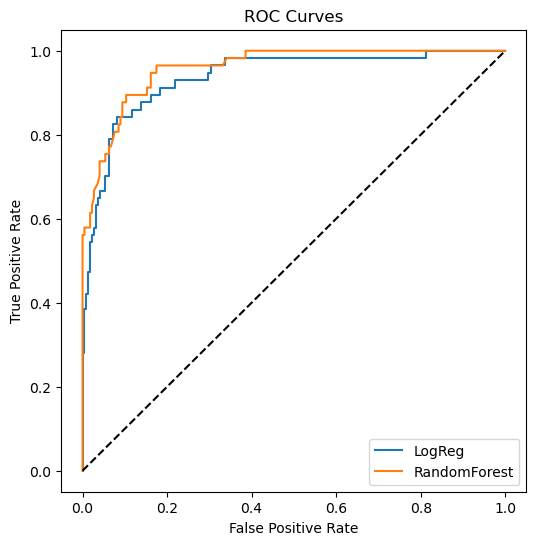

In [9]:

fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(6,6))
plt.plot(fpr_log, tpr_log, label="LogReg")
plt.plot(fpr_rf, tpr_rf, label="RandomForest")
plt.plot([0,1],[0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


## 🔎 Feature Importance

In [10]:

# Logistic coefficients
coefs = log_pipe.named_steps["clf"].coef_[0]
coef_df = pd.DataFrame({"feature": feature_cols, "coef": coefs}).sort_values("coef", ascending=False)
print("Top Logistic Regression Coefficients:")
display(coef_df.head(15))

# Random Forest importances
importances = rf_pipe.named_steps["clf"].feature_importances_
fi_df = pd.DataFrame({"feature": feature_cols, "importance": importances}).sort_values("importance", ascending=False)
print("Top Random Forest Features:")
display(fi_df.head(15))


Top Logistic Regression Coefficients:


,feature,coef
25,W,1.761872
11,RBI,1.258692
6,R,1.211467
7,H_x,1.200623
37,SO_y,1.190903
31,SV,0.863865
20,GIDP,0.718701
30,SHO,0.648803
0,birthYear,0.598440
44,IP,0.512350


Top Random Forest Features:


,feature,importance
49,yearid,0.065927
7,H_x,0.058824
6,R,0.058145
0,birthYear,0.051627
21,BA,0.048425
5,AB,0.044517
11,RBI,0.038884
25,W,0.033930
4,G_x,0.033112
24,OPS,0.031532


## 🧮 Predict a Player’s HOF Probability

In [11]:

# Build a mapping of player name to row
data["player_name"] = data["nameFirst"].fillna("") + " " + data["nameLast"].fillna("")
player_map = dict(zip(data["player_name"], data["playerID"]))

# Example: Try predicting Ken Griffey Jr. if exists
name_choice = "Ken Griffey Jr."

if name_choice in player_map:
    pid = player_map[name_choice]
    row = data[data["playerID"] == pid]
    feats_row = row[feature_cols].fillna(0)
    prob_rf = rf_pipe.predict_proba(feats_row)[:,1][0]
    prob_log = log_pipe.predict_proba(feats_row)[:,1][0]
    print(f"{name_choice} → Logistic={prob_log:.3f}, RandomForest={prob_rf:.3f}")
else:
    print(f"{name_choice} not in dataset.")


Ken Griffey Jr. not in dataset.
